In [ ]:
from google.colab import files
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

# path to zip file containing the dataset in Google Drive
!cp '/content/drive/My Drive/Database.zip' .

# extract the Database folder to the current directory
!unzip Database.zip -d ./

Mounted at /content/drive
Archive:  Database.zip
   creating: ./Database/
  inflating: ./__MACOSX/._Database   
  inflating: ./Database/Label.txt    
  inflating: ./__MACOSX/Database/._Label.txt  
  inflating: ./Database/.DS_Store    
  inflating: ./__MACOSX/Database/._.DS_Store  
   creating: ./Database/Image/
  inflating: ./__MACOSX/Database/._Image  
  inflating: ./Database/Image/6_P0_R30_00054.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P0_R30_00054.jpg  
  inflating: ./Database/Image/6_P10_R20_00027.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P10_R20_00027.jpg  
  inflating: ./Database/Image/6_P10_R20_00033.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P10_R20_00033.jpg  
  inflating: ./Database/Image/6_P0_R30_00040.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P0_R30_00040.jpg  
  inflating: ./Database/Image/6_P20_R50_00022.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P20_R50_00022.jpg  
  inflating: ./Database/Image/6_P50_R60_00007.jpg  
  inflating: ./__MACO

In [ ]:
label_path = '/content/Database/Label.txt'
image_folder = '/content/Database/Image'

# map the images with the label.txt
labels = pd.read_csv(label_path,
                     delimiter=' ',
                     header=None,
                     names=['Image', 'Pitch', 'Roll', 'Depth'])

print("First and last few rows of the labels:")
print(labels.head())
print(labels.tail())

First and last few rows of the labels:
               Image  Pitch  Roll     Depth
0  6_P0_R0_00001.jpg      0     0  0.611818
1  6_P0_R0_00002.jpg      0     0  0.693017
2  6_P0_R0_00003.jpg      0     0  0.457814
3  6_P0_R0_00004.jpg      0     0  0.105780
4  6_P0_R0_00005.jpg      0     0  0.296676
                    Image  Pitch  Roll     Depth
2011  6_P70_R70_00052.jpg     70    70  0.003353
2012  6_P70_R70_00053.jpg     70    70  0.958107
2013  6_P70_R70_00054.jpg     70    70  0.016327
2014  6_P70_R70_00055.jpg     70    70  0.000000
2015  6_P70_R70_00056.jpg     70    70  0.214759


In [ ]:
images = {}

# Loop through image filenames in Label.txt and load them
for img_name in labels['Image']:
    img_path = os.path.join(image_folder, img_name)
    try:
        images[img_name] = Image.open(img_path)  # Open the image
    except FileNotFoundError:
        print(f"Warning: {img_name} not found in {image_folder}")

In [ ]:
from sklearn.preprocessing import LabelEncoder

# combining the pitch and roll class into a single pose class
labels['Pose_Class'] = labels['Pitch'].astype(str) + '_' + labels['Roll'].astype(str)

#label encoding the combined class
label_encoder = LabelEncoder()
labels['Pose_Class_Label'] = label_encoder.fit_transform(labels['Pose_Class'])

In [ ]:
print(labels.head())
print(labels.tail())

               Image  Pitch  Roll     Depth Pose_Class  Pose_Class_Label
0  6_P0_R0_00001.jpg      0     0  0.611818        0_0                 0
1  6_P0_R0_00002.jpg      0     0  0.693017        0_0                 0
2  6_P0_R0_00003.jpg      0     0  0.457814        0_0                 0
3  6_P0_R0_00004.jpg      0     0  0.105780        0_0                 0
4  6_P0_R0_00005.jpg      0     0  0.296676        0_0                 0
                    Image  Pitch  Roll     Depth Pose_Class  Pose_Class_Label
2011  6_P70_R70_00052.jpg     70    70  0.003353      70_70                35
2012  6_P70_R70_00053.jpg     70    70  0.958107      70_70                35
2013  6_P70_R70_00054.jpg     70    70  0.016327      70_70                35
2014  6_P70_R70_00055.jpg     70    70  0.000000      70_70                35
2015  6_P70_R70_00056.jpg     70    70  0.214759      70_70                35


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns

In [ ]:
class PoseDataset(Dataset):
    def __init__(self, labels, transform=None):

        self.labels_df = labels  # Store the original DataFrame
        self.transform = transform
        self.image_folder = image_folder # Assign image_folder to self

    def __len__(self):
        return len(self.labels_df)  # Use the original DataFrame for length

    def __getitem__(self, idx):
        img_path = self.labels_df.iloc[idx]['Image']  # Use labels_df here
        img_path = os.path.join(self.image_folder, img_path)  # Construct full path using img_path, not img_name
        label = self.labels_df.iloc[idx]['Pose_Class_Label']  # Use labels_df here

        # Load image
        image = Image.open(img_path).convert("L")  # Grayscale

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# SPLITTING the data into 60:20:20

train_df, test_df = train_test_split(labels,
                                     test_size=0.2,
                                     random_state=42,
                                     stratify=labels['Pose_Class_Label'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.25,
                                    random_state=42,
                                    stratify=train_df['Pose_Class_Label'])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 1209
Validation samples: 403
Test samples: 404


In [ ]:
# AUGMENTATION

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),                  # Convert to 3 channels for resnet
    transforms.Resize((224, 224)),                                # Resize to 224x224
    transforms.RandomRotation(2),                                 # Random rotation within 5 degrees
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),  # Blurring effect
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),         # Random zoom (80%-120% scaling)
    transforms.ColorJitter(brightness=0.3),                       # Random brightness adjustment
    transforms.ToTensor(),                                        # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],              # Normalize for resnet
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
# datasets creation
train_dataset = PoseDataset(train_df, transform=train_transform)
val_dataset = PoseDataset(val_df, transform=val_test_transform)
test_dataset = PoseDataset(test_df, transform=val_test_transform)

# dataloaders creation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
for images, labels in train_loader:
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)
    break

Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


In [ ]:
# VISION TRANsFORMER

from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch.nn as nn

class CustomViTClassifier(nn.Module):
    def __init__(self, num_classes=36, dropout_rate=0.3):
        super(CustomViTClassifier, self).__init__()
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)


        # Modify the final classification head
        self.vit.heads = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(self.vit.heads.head.in_features, num_classes)
        )

    def forward(self, x):
        return self.vit(x)

# Initialize the model
num_classes = 36
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomViTClassifier(num_classes=num_classes, dropout_rate=0.3)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 113MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to the chosen device

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
def train_model(model, train_loader, val_loader, epochs=10):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)  # Use global criterion

            # Backward pass and optimization
            optimizer.zero_grad()  # Use global optimiser
            loss.backward()
            optimizer.step()

            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        # Calculate training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)  # Use global criterion

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += loss.item()

        # Calculate validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Update the learning rate based on validation loss
        scheduler.step()  # Use global scheduler

        current_lr = optimizer.param_groups[0]['lr']

        # Printing epoch results
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, "
              f"LR: {current_lr:.6f}")


    plt.figure(figsize=(14, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", color='red')
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color='royalblue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy", color='limegreen')
    plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", color='darkorange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch [1/10], Train Loss: 3.5570, Train Accuracy: 0.0471, Validation Loss: 3.3521, Validation Accuracy: 0.1886, LR: 0.000010
Epoch [2/10], Train Loss: 3.1004, Train Accuracy: 0.2068, Validation Loss: 2.7579, Validation Accuracy: 0.4318, LR: 0.000010
Epoch [3/10], Train Loss: 2.3999, Train Accuracy: 0.4450, Validation Loss: 1.9810, Validation Accuracy: 0.6774, LR: 0.000010
Epoch [4/10], Train Loss: 1.6885, Train Accuracy: 0.7097, Validation Loss: 1.4378, Validation Accuracy: 0.7667, LR: 0.000010
Epoch [5/10], Train Loss: 1.1692, Train Accuracy: 0.8801, Validation Loss: 0.9793, Validation Accuracy: 0.9429, LR: 0.000001
Epoch [6/10], Train Loss: 0.8722, Train Accuracy: 0.9462, Validation Loss: 0.9119, Validation Accuracy: 0.9454, LR: 0.000001
Epoch [7/10], Train Loss: 0.8325, Train Accuracy: 0.9504, Validation Loss: 0.8773, Validation Accuracy: 0.9454, LR: 0.000001
Epoch [8/10], Train Loss: 0.7968, Train Accuracy: 0.9462, Validation Loss: 0.8400, Validation Accuracy: 0.9553, LR: 0.000001


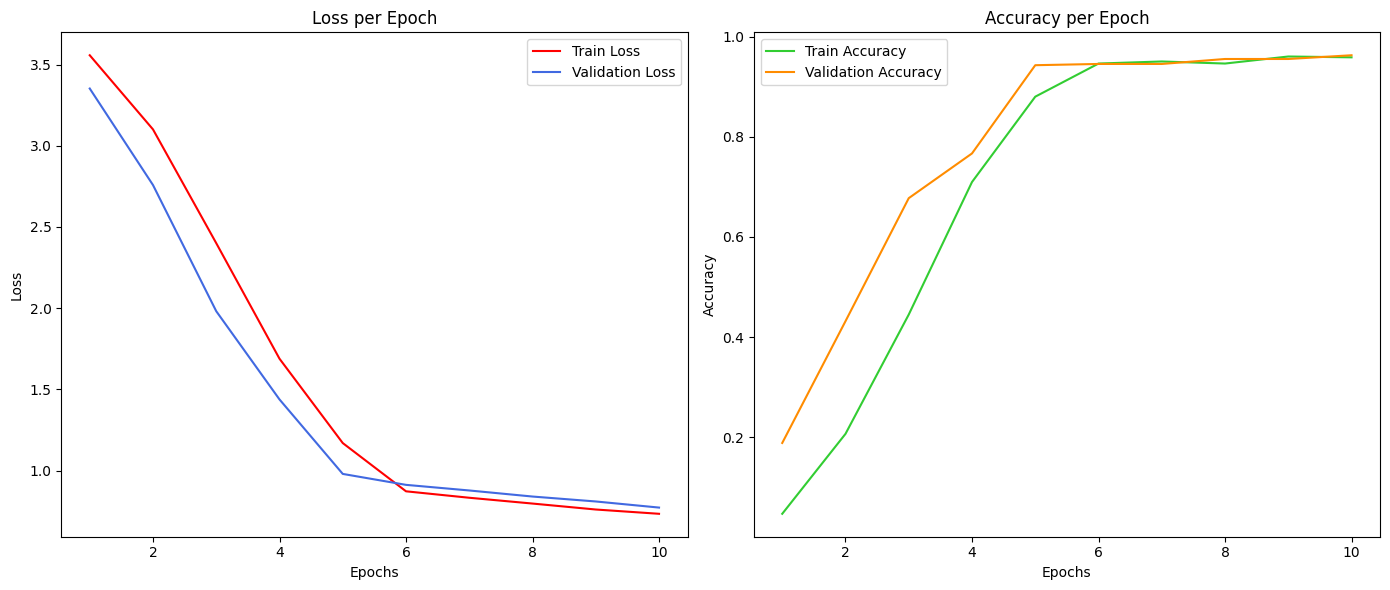

In [ ]:
train_model(model, train_loader, val_loader, epochs=10)

In [ ]:
# Testing and Evaluation Function with Confusion Matrix Display
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode

    y_true = []
    y_pred = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted classes

            # Append true and predicted labels for evaluation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    print(f"Test Accuracy: {accuracy:.4f}")

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)], output_dict=True)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)]))

    # Calculate overall metrics (macro averaged)
    overall_precision = report["macro avg"]["precision"]
    overall_recall = report["macro avg"]["recall"]
    overall_f1 = report["macro avg"]["f1-score"]

    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1-Score: {overall_f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(num_classes)],
                yticklabels=[str(i) for i in range(num_classes)])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

Test Accuracy: 0.9653

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.45      0.62        11
           2       0.65      1.00      0.79        11
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        11
           6       0.92      1.00      0.96        12
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00        11
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00        11
          12       1.00      1.00      1.00        11
          13       1.00      0.82      0.90        11
          14       1.00      1.00      1.00        12
          15       1.00      1.00      1.00        11
          16       1.00      1.00  

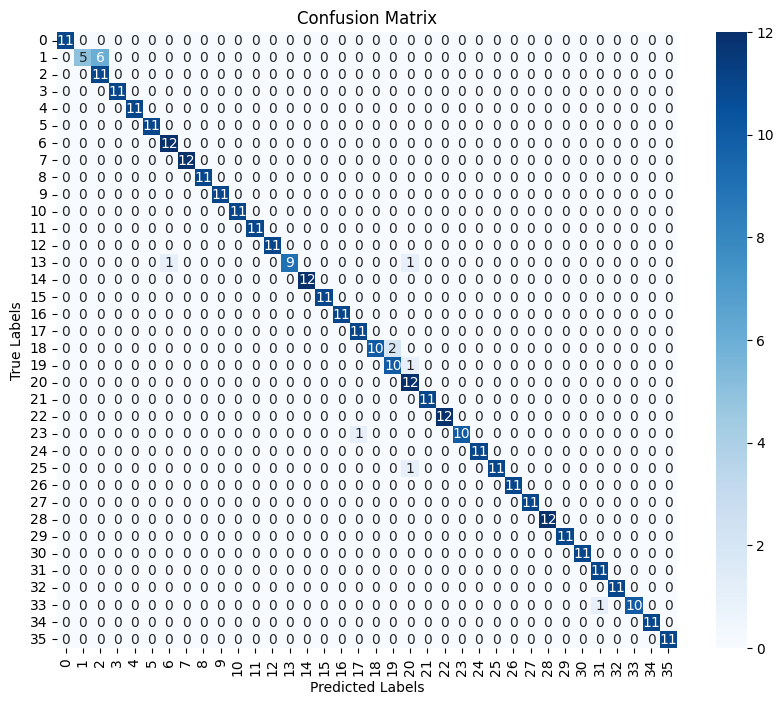

In [ ]:
evaluate_model(model, test_loader)